# Comparative Analysis of User Revenue Prediction Based on Decision Tree and Random Forest

In [2]:
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

## data loading

In [3]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
train_data = pd.read_csv('Census Income Data Set/adult.data', names=column_names, sep=',\s', na_values='?', engine='python')
test_data = pd.read_csv('Census Income Data Set/adult.test', names=column_names, sep=',\s', na_values='?', skiprows=1, engine='python')

print(train_data.head())
print(test_data.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

## data preprocessing

In [4]:
train_data['income'] = train_data['income'].str.strip().replace({'<=50K': 0, '>50K': 1})
test_data['income'] = test_data['income'].str.strip().str.replace('.', '', regex=False).replace({'<=50K': 0, '>50K': 1})

X_train = train_data.drop('income', axis=1)
y_train = train_data['income']
X_test = test_data.drop('income', axis=1)
y_test = test_data['income']

numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  
        ]), numeric_features),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)


## decision tree

In [5]:
# using grid search
param_grid = {
    'max_depth': [15, 20, 25, 30],  
    'min_samples_split': [5, 10, 15],  
    'min_samples_leaf': [1, 3, 5], 
    'max_features': ['sqrt', 'log2', None]
}

decision_tree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy', return_train_score=True)

start_time = time.time()
grid_search.fit(X_train_res, y_train_res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

results = grid_search.cv_results_

for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Parameters: {params} => Accuracy: {mean_score:.4f}")
print("Best parameters found:", grid_search.best_params_)
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

Training completed in 67.44 seconds.
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5} => Accuracy: 0.8272
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10} => Accuracy: 0.8249
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15} => Accuracy: 0.8217
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5} => Accuracy: 0.8256
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10} => Accuracy: 0.8269
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15} => Accuracy: 0.8191
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5} => Accuracy: 0.8209
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10} => Accurac

In [6]:
best_model1 = grid_search.best_estimator_
y_pred1 = best_model1.predict(X_test_preprocessed)

print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Classification Report:")
print(classification_report(y_test, y_pred1))

Accuracy: 0.814937657392052
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     12435
           1       0.58      0.75      0.66      3846

    accuracy                           0.81     16281
   macro avg       0.75      0.79      0.76     16281
weighted avg       0.84      0.81      0.82     16281



## random forest

In [7]:
# Using randomized search
param_dist = {
    'n_estimators': randint(50, 200),  
    'max_depth': randint(5, 20),  
    'min_samples_split': randint(10, 30), 
    'min_samples_leaf': randint(2, 10), 
    'max_features': ['sqrt', 'log2', None] 
}

random_forest = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, 
                                   n_iter=20, cv=3, n_jobs=-1, random_state=42, scoring='accuracy')

start_time = time.time()
random_search.fit(X_train_res, y_train_res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

results = random_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Parameters: {params} => Accuracy: {mean_score:.4f}")
print("Best parameters found:", random_search.best_params_)
print(f"Best Accuracy: {random_search.best_score_:.4f}")

Training completed in 240.99 seconds.
Parameters: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 121} => Accuracy: 0.8454
Parameters: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 28, 'n_estimators': 124} => Accuracy: 0.8524
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 17, 'n_estimators': 180} => Accuracy: 0.8534
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 21, 'n_estimators': 87} => Accuracy: 0.8421
Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 21, 'n_estimators': 107} => Accuracy: 0.8125
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 26, 'n_estimators': 108} => Accuracy: 0.8414
Parameters: {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 25, 'n_e

In [8]:
best_model2 = random_search.best_estimator_
y_pred2 = best_model2.predict(X_test_preprocessed)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:")
print(classification_report(y_test, y_pred2))

Accuracy: 0.8359437380996253
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     12435
           1       0.62      0.77      0.69      3846

    accuracy                           0.84     16281
   macro avg       0.77      0.81      0.79     16281
weighted avg       0.85      0.84      0.84     16281



## Model performance comparison

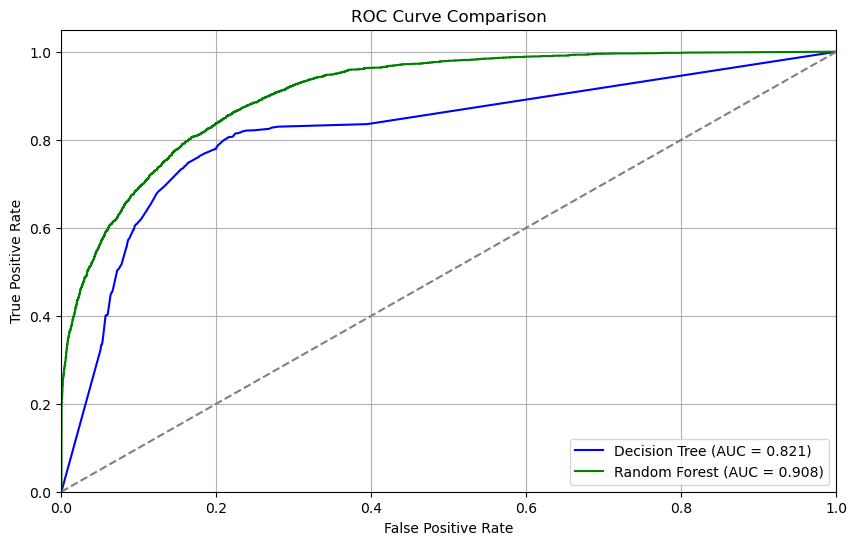

      Metric  Decision Tree  Random Forest
0   Accuracy       0.814938       0.835944
1        AUC       0.820773       0.908246
2   Log Loss       2.881557       0.353370
3  Precision       0.584603       0.624233
4         F1       0.656403       0.688513


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, log_loss, precision_recall_fscore_support

y_pred_prob_tree = best_model1.predict_proba(X_test_preprocessed)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)
auc_tree = auc(fpr_tree, tpr_tree)
accuracy_tree = accuracy_score(y_test, y_pred1)
logloss_tree = log_loss(y_test, y_pred_prob_tree)
precision_tree, recall_tree, f1_tree, _ = precision_recall_fscore_support(y_test, y_pred1, average='binary')

y_pred_prob_forest = best_model2.predict_proba(X_test_preprocessed)[:, 1]
fpr_forest, tpr_forest, _ = roc_curve(y_test, y_pred_prob_forest)
auc_forest = auc(fpr_forest, tpr_forest)
accuracy_forest = accuracy_score(y_test, y_pred2)
logloss_forest = log_loss(y_test, y_pred_prob_forest)
precision_forest, recall_forest, f1_forest, _ = precision_recall_fscore_support(y_test, y_pred2, average='binary')

plt.figure(figsize=(10, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.3f})', color='blue')
plt.plot(fpr_forest, tpr_forest, label=f'Random Forest (AUC = {auc_forest:.3f})', color='green')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC', 'Log Loss', 'Precision', 'F1'],
    'Decision Tree': [accuracy_tree, auc_tree, logloss_tree, precision_tree, f1_tree],
    'Random Forest': [accuracy_forest, auc_forest, logloss_forest, precision_forest, f1_forest]
})
print(results_df)